In [2]:
import numpy as np
import gym
import ppaquette_gym_doom
from ppaquette_gym_doom.wrappers import SetResolution, ToDiscrete
from gym.wrappers import SkipWrapper

from gym import wrappers


# (see https://github.com/ppaquette/gym-doom/blob/master/ppaquette_gym_doom/doom_basic.py)
def create_env(seed=None, monitor_directory=None, force=True, resume=False):
    env_spec = gym.spec('ppaquette/DoomBasic-v0')
    env_spec.id = 'DoomBasic-v0'
    env = env_spec.make()

    if seed is not None:
        env.seed(seed)

    if monitor_directory is not None:
        env = wrappers.Monitor(env, monitor_directory, force=True, resume=resume, mode='training', 
                               video_callable=lambda episode_id: episode_id % 100 == 0)

    return SkipWrapper(repeat_count=4)(
        ToDiscrete('minimal')(env))

NOOP, SHOOT, RIGHT, LEFT = 0, 1, 2, 3

(480, 640, 3)


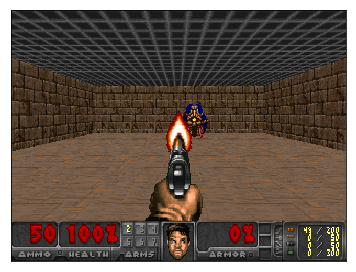

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
from skimage.transform import resize
from skimage.color import rgb2gray

WIDTH, HEIGHT, CHANNELS = 200, 150, 1


def pre_process(obs, size=(HEIGHT, WIDTH)):
    return resize(rgb2gray(obs), size).reshape((-1,) + size)

env = create_env()
obs = env.reset()
obs, _, _, _ = env.step(action=1)

plt.figure(figsize=[6, 6])

print(obs.shape)
def show(observation):
    if CHANNELS == 1:
        plt.imshow(observation.squeeze(), interpolation=None, cmap='gray')
    else:
        plt.imshow(observation, interpolation=None)
    plt.xticks([]); plt.yticks([]);
    
show(obs)
env.close()

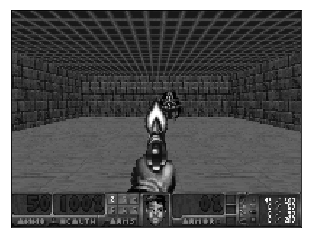

In [5]:
show(pre_process(obs))

## Deep Q-learning

 * https://github.com/coreylynch/async-rl/blob/master/model.py and https://github.com/tflearn/tflearn/blob/master/examples/reinforcement_learning/atari_1step_qlearning.py with 84 x 84 images

```
    net = tflearn.conv_2d(net, 32, 8, strides=4, activation='relu')
    net = tflearn.conv_2d(net, 64, 4, strides=2, activation='relu')
    net = tflearn.fully_connected(net, 256, activation='relu')
```

 * https://github.com/ebonyclock/deep_rl_vizdoom/blob/master/networks/common.py#L20 with 80 x 60 images
 
```
    conv1 = layers.conv2d(img_input, num_outputs=8, kernel_size=[6, 6], stride=3, padding="VALID", ...)
    conv2 = layers.conv2d(conv1, num_outputs=8, kernel_size=[3, 3], stride=2, padding="VALID", ...)

```
 * From http://vizdoom.cs.put.edu.pl/tutorial#learning with images (30, 45)!
```
dqn = Conv2DLayer(dqn, num_filters=8, filter_size=[6, 6], nonlinearity=rectify, W=HeUniform("relu"),b=Constant(.1), stride=3)
dqn = Conv2DLayer(dqn, num_filters=8, filter_size=[3, 3],nonlinearity=rectify, W=HeUniform("relu"),b=Constant(.1), stride=2)
dqn = DenseLayer(dqn, num_units=128, nonlinearity=rectify, W=HeUniform("relu"), b=Constant(.1))
```
 

In [102]:
import tensorflow as tf
from keras import backend as K

from keras.layers import Input, Dense, Convolution2D, Flatten, Activation, MaxPooling2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

sess = tf.InteractiveSession()
K.set_session(sess)

def create_q_model(conv1_weights=None, conv2_weights=None, dense1_weights=None, dense2_weights=None):

    input_image = Input(shape=(CHANNELS, HEIGHT, WIDTH))
    x = Convolution2D(nb_filter=4, nb_row=6, nb_col=6, subsample=(3, 3), border_mode='same', weights=conv1_weights
                     )(input_image)
    x = Activation('relu')(x)
    x = Convolution2D(nb_filter=4, nb_row=3, nb_col=3, subsample=(2, 2),  border_mode='same', weights=conv2_weights
                     )(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(dim_ordering='th', pool_size=(3, 3))(x)
    x = Flatten()(x)
    x = Dense(128, init='normal', weights=dense1_weights)(x)
    x = Activation('relu')(x)
    action_values = Dense(4, init='normal', weights=dense2_weights)(x)
    model = Model(input=input_image, output=action_values)
    model.compile(loss='mse', optimizer=Adam())
    
    return model


acting_model = create_q_model()
target_model = create_q_model()

def copy_model(model):
    conv1_weights =  [w.eval() for w in model.layers[1].weights]
    conv2_weights = [w.eval() for w in model.layers[3].weights]
    dense1_weights = [w.eval() for w in model.layers[7].weights]
    dense2_weights = [w.eval() for w in model.layers[9].weights]
    return create_q_model(conv1_weights, conv2_weights, dense1_weights, dense2_weights)

acting_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_845 (InputLayer)           (None, 1, 150, 200)   0                                            
____________________________________________________________________________________________________
convolution2d_1689 (Convolution2 (None, 4, 50, 67)     148         input_845[0][0]                  
____________________________________________________________________________________________________
activation_2529 (Activation)     (None, 4, 50, 67)     0           convolution2d_1689[0][0]         
____________________________________________________________________________________________________
convolution2d_1690 (Convolution2 (None, 4, 25, 34)     148         activation_2529[0][0]            
___________________________________________________________________________________________

## Collecting and preparing experiences for learning

In [103]:
# from https://docs.python.org/3/library/itertools.html#recipes
from itertools import tee, zip_longest

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx
    args = [iter(iterable)] * n
    return zip_longest(fillvalue=fillvalue, *args)

In [104]:
from collections import namedtuple, deque
from itertools import islice 
import operator
import functools
import random


SARE = namedtuple('SAR', ['state', 'action', 'reward', 'end'])
Experience = namedtuple('Experience', ['previous_state', 'action', 'reward', 'next_state', 'end'])


class EpsilonGreedyQAgent(object):
    def __init__(self, model, epsilon=.1):
        self.model = model
        self.epsilon = epsilon

    def act(self, observation, reward, done):
        if random.uniform(0, 1) <= self.epsilon:
            return random.choice([NOOP, SHOOT, LEFT, RIGHT])
        else:
            return self.model.predict(observation[np.newaxis])[0].argmax()

def generate_sares(env, agent, episode_count=2000):
    reward = 0
    done = False

    for i in range(episode_count):
        episode_sares = []
        observation = pre_process(env.reset())
        while True:
            action = agent.act(observation, reward, done)
            new_observation, reward, done, _ = env.step(action)
            sare = SARE(observation, action, reward, done)
            episode_sares.append(sare)
            yield sare

            if done:
                if (i % 10) == 0:
                    print('episode {i} with {steps} steps, {reward:.0f} reward and #actions {actions}'.format(
                        i=i, steps=len(episode_sares), reward=sum(sar.reward for sar in episode_sares),
                        actions=np.bincount([sar.action for sar in episode_sares])))
                break
            else:
                observation = pre_process(new_observation)


def to_experiences(sares):
    return (
        Experience(previous_s, a, r, next_s, end) 
        for (previous_s, a, r, end), (next_s, _, _, _) 
        in pairwise(sares)
    )

import itertools as it

class ExperiencesReplay:
    def __init__(self, experiences_iterable, memory_size=1000, batch_size=32, replay_ratio=.25):
        self.experiences_iterable = experiences_iterable
        self.batch_size = batch_size
        self.replay_ratio = replay_ratio
        self.memory = deque(maxlen=memory_size)

    def __iter__(self):
        return self

    def __next__(self):
        new_experiences = list(it.islice(self.experiences_iterable, int(self.replay_ratio * self.batch_size)))
        if len(new_experiences) == 0:
            raise StopIteration()
        
        for exp in new_experiences:
            self.memory.appendleft(exp)
        
        experiences_batch = list(e for e in self.memory if e.reward > 0)[:5] \
            + random.choices(self.memory, k=self.batch_size)
        random.shuffle(experiences_batch)
        return experiences_batch
    
env = create_env()

experiences = to_experiences(generate_sares(env, EpsilonGreedyQAgent(acting_model), episode_count=2))

streamlined_experience_batches = grouper(experiences, n=10)

print('streamlined_experience_batches')
print(len(list(next(streamlined_experience_batches))))

print('replayed_batches')
replayed_batches = ExperiencesReplay(experiences, memory_size=100)

for b in replayed_batches:
    print(len(b), len(replayed_batches.memory))

streamlined_experience_batches
10
replayed_batches
32 8
32 16
32 24
32 32
32 40
32 48
32 56
episode 0 with 70 steps, -450 reward and #actions [ 2 42  1 25]
32 64
32 72
32 80
32 88
32 96
32 100
32 100
32 100
32 100
32 100


## Training

In [105]:
class DeepQNetworkTrainer:
    
    MINI_BATCH_SIZE = 128
    UPDATE_TARGET_EVERY_N_BACTHES = 2
    
    def __init__(self, acting_model, target_model, double_q=False, gamma=.99, reward_clip=5):
        self.acting_model = acting_model
        self.target_model = target_model
        self.double_q = double_q
        
        self.gamma = gamma
        self.reward_clip = reward_clip

        # counter to periodically set target_model <- acting_model
        self.trained_epochs = 0
    
    def fit_episodes(self, experiences_batch):
        prev_frames, target_action_rewards = self._batch_to_input_targets(experiences_batch, double_q=self.double_q)
        self.acting_model.fit(x=prev_frames, y=target_action_rewards, batch_size=self.MINI_BATCH_SIZE, nb_epoch=1, verbose=0)
        self.trained_epochs += 1

        if (self.trained_epochs % self.UPDATE_TARGET_EVERY_N_BACTHES) == 0:
            self.target_model = copy_model(self.acting_model)

    def _batch_to_input_targets(self, experiences_batch, double_q=False):
        
        prev_frames, actions, rewards, next_frames, is_ends = map(np.asarray, zip(*experiences_batch))
        n_samples = len(experiences_batch)
        clipped_rewards = np.clip(rewards, -np.inf, self.reward_clip)

        if double_q:
            greedy_actions = self.acting_model.predict(next_frames).argmax(axis=1)
            actions_target_values = self.target_model.predict(next_frames)[np.arange(n_samples), greedy_actions]            
            targets = clipped_rewards + self.gamma * (1 - is_ends) * actions_target_values
        else:
            # Transcription of the Q-learning target formula
            targets = clipped_rewards + self.gamma * (1 - is_ends) * self.target_model.predict(next_frames).max(axis=1)

        target_action_rewards = self.target_model.predict(prev_frames)
        target_action_rewards[np.arange(n_samples), actions] = targets
        return prev_frames, target_action_rewards
    
trainer = DeepQNetworkTrainer(acting_model, target_model)

In [106]:
import itertools as it

N_EPISODES = 1500

directory = 'tmp/DoomBasic_dqn_resize_rgb'
env = create_env(monitor_directory=directory)

agent = EpsilonGreedyQAgent(acting_model, epsilon=.1)
experiences = to_experiences(generate_sares(env, agent, episode_count=N_EPISODES))
experience_batches = ExperiencesReplay(
    experiences,
    memory_size=1000, batch_size=DeepQNetworkTrainer.MINI_BATCH_SIZE)

for experience_batch in experience_batches:
    trainer.fit_episodes(experience_batch)

# final greedy episodes
sares = list(generate_sares(env, EpsilonGreedyQAgent(acting_model, epsilon=0), episode_count=100))

env.close()
gym.upload(directory, api_key='sk_bNZUvCfkTfabQCoKoKbjFA')

[2017-03-14 18:41:01,314] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-03-14 18:41:01,316] Clearing 34 monitor files from previous run (because force=True was provided)
[2017-03-14 18:41:01,893] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_resize_rgb/openaigym.video.1.51108.video000000.mp4


episode 0 with 70 steps, -395 reward and #actions [33 16  1 20]
episode 10 with 70 steps, -360 reward and #actions [ 2  3  2 63]
episode 20 with 1 steps, 96 reward and #actions [0 1]
episode 30 with 70 steps, -355 reward and #actions [ 1  1 64  4]
episode 40 with 70 steps, -360 reward and #actions [ 2  2  2 64]
episode 50 with 70 steps, -355 reward and #actions [ 3  1 66]
episode 60 with 70 steps, -355 reward and #actions [ 0  1  4 65]
episode 70 with 70 steps, -470 reward and #actions [ 2 64  2  2]
episode 80 with 70 steps, -475 reward and #actions [ 0 69  1]
episode 90 with 70 steps, -355 reward and #actions [28  1  7 34]


[2017-03-14 19:32:41,238] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_resize_rgb/openaigym.video.1.51108.video000100.mp4


episode 100 with 70 steps, -470 reward and #actions [ 1 65  3  1]
episode 110 with 1 steps, 96 reward and #actions [0 1]
episode 120 with 70 steps, -470 reward and #actions [ 3 65  2]
episode 130 with 70 steps, -470 reward and #actions [ 0 67  1  2]
episode 140 with 70 steps, -355 reward and #actions [ 2  1  1 66]
episode 150 with 1 steps, 96 reward and #actions [0 1]
episode 160 with 70 steps, -475 reward and #actions [ 1 65  1  3]
episode 170 with 1 steps, 96 reward and #actions [0 1]
episode 180 with 70 steps, -475 reward and #actions [ 3 66  1]
episode 190 with 48 steps, -218 reward and #actions [ 2 44  2]


[2017-03-14 20:15:33,992] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_resize_rgb/openaigym.video.1.51108.video000200.mp4


episode 200 with 70 steps, -355 reward and #actions [59  1  0 10]
episode 210 with 70 steps, -475 reward and #actions [ 1 68  1]
episode 220 with 70 steps, -475 reward and #actions [ 1 64  3  2]
episode 230 with 70 steps, -450 reward and #actions [ 0 56  0 14]
episode 240 with 70 steps, -395 reward and #actions [ 1 15  1 53]
episode 250 with 70 steps, -470 reward and #actions [ 2 68]
episode 260 with 68 steps, -351 reward and #actions [ 1 64  1  2]
episode 270 with 70 steps, -365 reward and #actions [ 1  3 64  2]
episode 280 with 70 steps, -465 reward and #actions [ 2 40  5 23]
episode 290 with 10 steps, 39 reward and #actions [ 0 10]


[2017-03-14 21:02:47,741] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_resize_rgb/openaigym.video.1.51108.video000300.mp4


episode 300 with 70 steps, -470 reward and #actions [ 2 64  1  3]
episode 310 with 18 steps, -18 reward and #actions [ 0 18]
episode 320 with 8 steps, 53 reward and #actions [0 5 3]
episode 330 with 5 steps, 72 reward and #actions [0 3 2]
episode 340 with 8 steps, 53 reward and #actions [0 6 2]
episode 350 with 70 steps, -475 reward and #actions [ 0 67  1  2]
episode 360 with 21 steps, -37 reward and #actions [ 0 21]
episode 370 with 15 steps, 1 reward and #actions [ 0 15]
episode 380 with 70 steps, -475 reward and #actions [ 1 69]
episode 390 with 70 steps, -435 reward and #actions [ 3 35  0 32]


[2017-03-14 21:57:24,715] Starting new video recorder writing to /Users/gui/Dev/rl-study/tmp/DoomBasic_dqn_resize_rgb/openaigym.video.1.51108.video000400.mp4


episode 400 with 70 steps, -390 reward and #actions [ 0 10 58  2]
episode 410 with 1 steps, 96 reward and #actions [0 1]
episode 420 with 70 steps, -450 reward and #actions [ 2 32  2 34]


KeyboardInterrupt: 

## Visual debugging

http://cs231n.github.io/understanding-cnn/


array([[-72.36509705, -73.6049118 , -72.43689728, -74.15101624]], dtype=float32)

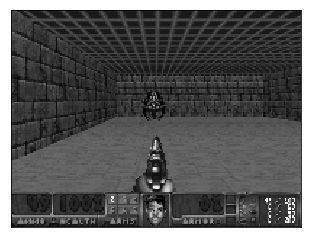

In [111]:
monster_in_front = 6

obs = sares[monster_in_front].state
show(obs)
acting_model.predict(np.array([obs]))

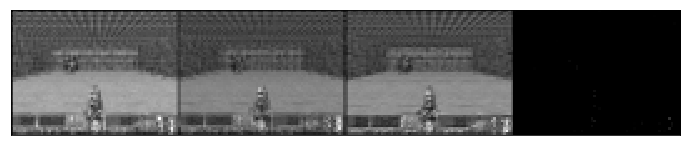

In [108]:
to_conv1_relu = Sequential(layers=acting_model.layers[:3])

image_activation_by_filters = to_conv1_relu.call(np.array([obs])).eval()

plt.figure(figsize=(12, 12))
show(np.hstack(image_activation_by_filters.squeeze()));

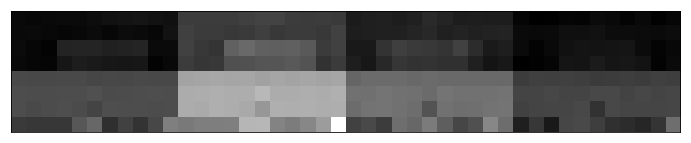

In [110]:
to_conv2_relu = Sequential(layers=acting_model.layers[:6])

image_activation_by_filters = to_conv2_relu.call(np.array([obs])).eval()

plt.figure(figsize=(12, 12))
show(np.hstack(image_activation_by_filters.squeeze()));

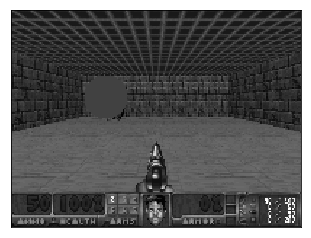

In [95]:
from skimage.draw import circle

masked_obs = obs.copy().squeeze()
center_mask = 60, 100
left_mask = 60, 65
rr, cc = circle(*left_mask, radius=15, shape=masked_obs.shape)
masked_obs[rr, cc] = np.mean(obs)
show(masked_obs)

In [96]:
acting_model.predict(masked_obs.reshape((1, -1, HEIGHT, WIDTH)))

array([[-70.03417206, -74.47888947, -70.20250702, -69.3894577 ]], dtype=float32)

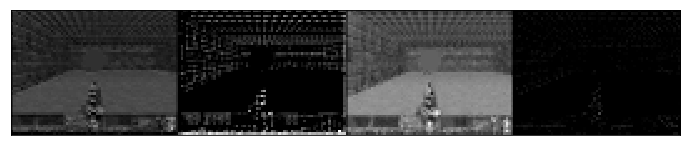

In [89]:
to_conv1_relu = Sequential(layers=acting_model.layers[:3])

image_activation_by_filters = to_conv1_relu.call(masked_obs.reshape((1, -1, HEIGHT, WIDTH))).eval()

plt.figure(figsize=(12, 12))
show(np.hstack(image_activation_by_filters.squeeze()));